# Multivariate Morphology on Lattice

In [1]:
import sys
sys.path.append('/home/commun/tp-morpho/')
from tp_init import *

### Documentation

#### Smil images <-> numpy arrays

The functions below allow the conversion of grayscale and color Smil images to numpy arrays: 

* <code>npArray = smilToNP(im)</code>: converts the grayscale image <code>im</code> to the numpy array <code>npArray</code> of size <code>(im.getWidth(), im.getHeight())</code>.

* <code>smilIm =  npToSmil(npArray)</code>: converts the numpy array <code>npArray</code> to the grayscale image <code>smilIm</code> of size <code>npArray.shape</code>.

* <code>arr = smilToNP3(im)</code>: converts a color image <code>im</code> to a numpy array of size <code>(im1.getWidth(), im1.getHeight(), 3)</code>.

* <code>smilIm =  npToSmil3(npArray)</code>: converts a 3D numpy array to a color image of size <code>npArray.shape</code>.



#### The class <code>smilImageToLattice</code>

The class is instantiated with a Smil image and builds a total ordering on its color values, based on luminance, saturation or Euclidean norm (method <code>compute_order</code>).



In [3]:
class smilImageToLattice:
    """
    Class of Image to Lattice Transform. 
    If Unique==True then lattice is computed only on spectral different values
    
    Velasco-Forero, Santiago and Angulo, Jesus. Supervised Ordering in R^p: 
    Application to Morphological Processing of Hyperspectral Images. 
    IEEE Transactions on Image Processing, 2011, vol. 20, no 11, p. 3301-3308.
    """
    def __init__(self,smilImage,unique=True,type_ordering='norm',verbose=False):
        image=smilToNP3(smilImage)
        self.nr,self.nc,self.nb = image.shape
        self.values=np.reshape(np.double(image),[self.nr*self.nc,self.nb])
        self.unique=unique
        self.verbose=verbose
        self.type_ordering=type_ordering
        if self.unique:
            self.values,self.inverse_unique=np.unique(self.values,axis=0,return_inverse=True)
 
    def compute_order(self):
        if self.type_ordering=='luminance':
            #Y = 0.2125 R + 0.7154 G + 0.0721 B
            #Luminance 
            coeffs = np.array([0.2125, 0.7154, 0.0721], dtype=self.values.dtype)
            self.hvalues = np.matmul(self.values,coeffs)
        if self.type_ordering=='saturation':
            #Saturation 
            maxv = np.max(self.values,axis=1)
            minv = np.min(self.values,axis=1)
            epsilon = np.finfo(np.double).eps
            self.hvalues = (maxv - minv)/(maxv + epsilon)
        else:
            #Compute Vector-wise norm
            self.hvalues=np.linalg.norm(self.values,axis=1) 
        
        self.B=np.argsort(self.hvalues) #Sort h values to compute lattice. 
        self.lattice=np.zeros(len(self.hvalues),dtype=np.uint32) 
        self.lattice[self.B]=np.arange(len(self.hvalues),dtype=np.uint32) #Create an lattice from order on B.
        if self.unique:
            self.lattice=self.lattice[self.inverse_unique]
        if self.verbose:
            print('Number of Different Colors:',np.max(self.lattice))
            print('Ordering Computed by:',self.type_ordering)
        
    def mapping_back(self,lattice):
        #From lattice values to Original colors
        npIm=np.int16(np.reshape(self.values[self.B[lattice],:],[self.nr,self.nc,self.nb]))
        smIm=npToSmil3(npIm)
        return smIm 
    
    def mapping_back_hvalues(self,lattice):
        #From lattice values to Original colors
        npIm=np.reshape(self.hvalues[self.B[lattice]],[self.nr,self.nc])
        smIm=npToSmil(npIm)
        return smIm
    
    def apply_operator(self,operator,SE):
        #To apply an operator on lattice.
        smLattice=npToSmil(np.reshape(self.lattice,[self.nr,self.nc]))
        operator(smLattice,smLattice,SE)
        return self.mapping_back(smLattice)
    
    def iterate_operator(self,operator,SE,niters=1):
        #To apply an operator on lattice.
        smLattice=npToSmil(np.reshape(self.lattice,[self.nr,self.nc]))
        temp=Image(smLattice)
        copy(smLattice,temp)
        for i in range(niters):
            operator(temp,smLattice,SE)
            copy(smLattice,temp)
        newLattice=smilToNP(smLattice)
        return self.mapping_back(newLattice.flatten())


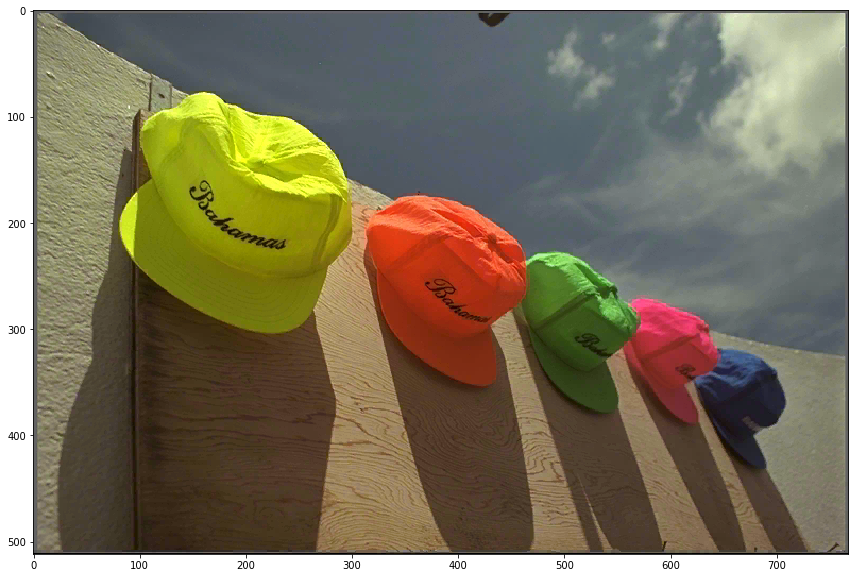

Number of Different Colors: 7843
Ordering Computed by: norm


In [4]:
im = Image(images_dir+"Color/kodim03.png")
disp(im)
lattim = smilImageToLattice(im,verbose=True)
lattim.compute_order()

h-values per pixels
npToSmil: float64


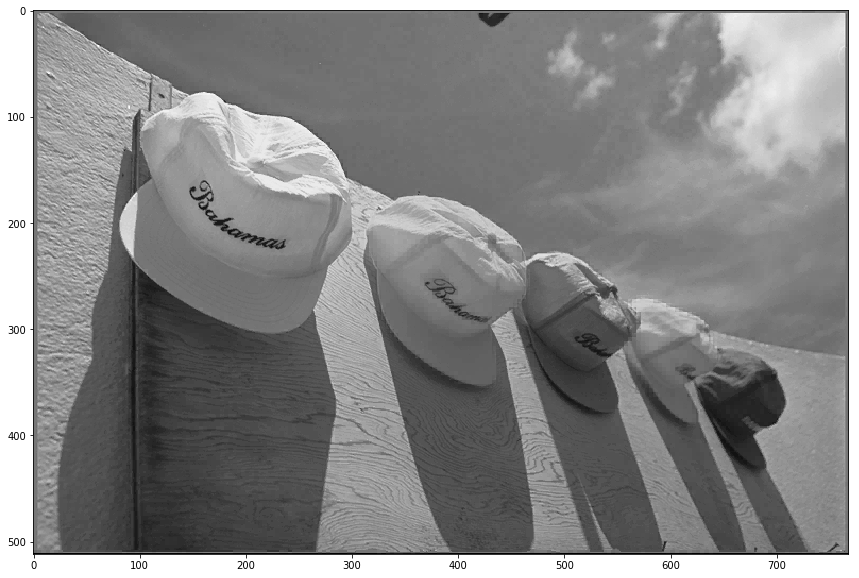

437


In [5]:
print('h-values per pixels')
hIm=lattim.mapping_back_hvalues(lattim.lattice)
#disp(hIm, True)
disp(hIm, norm = True)
print(maxVal(hIm))

Lattice from h-ordering
npToSmil: uint32


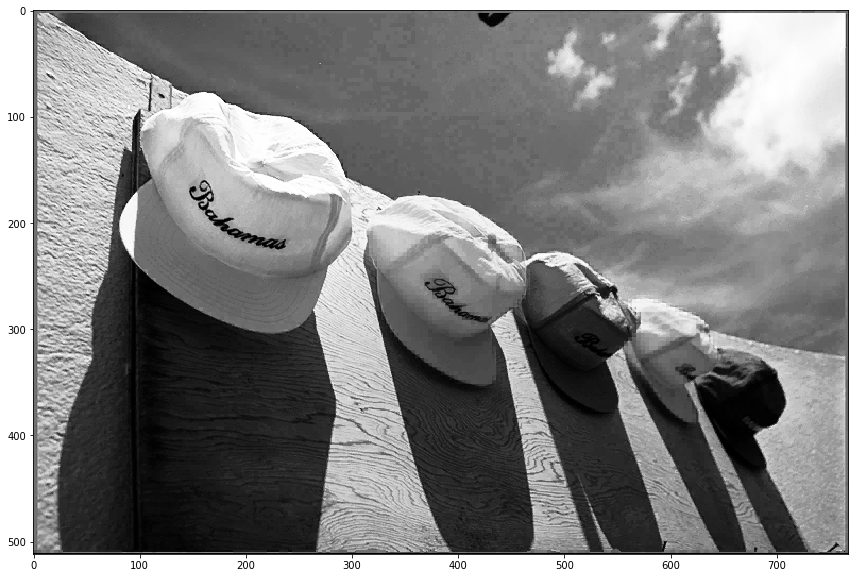

Mapping back from Lattice
npToSmil: uint8
npToSmil: uint8
npToSmil: uint8


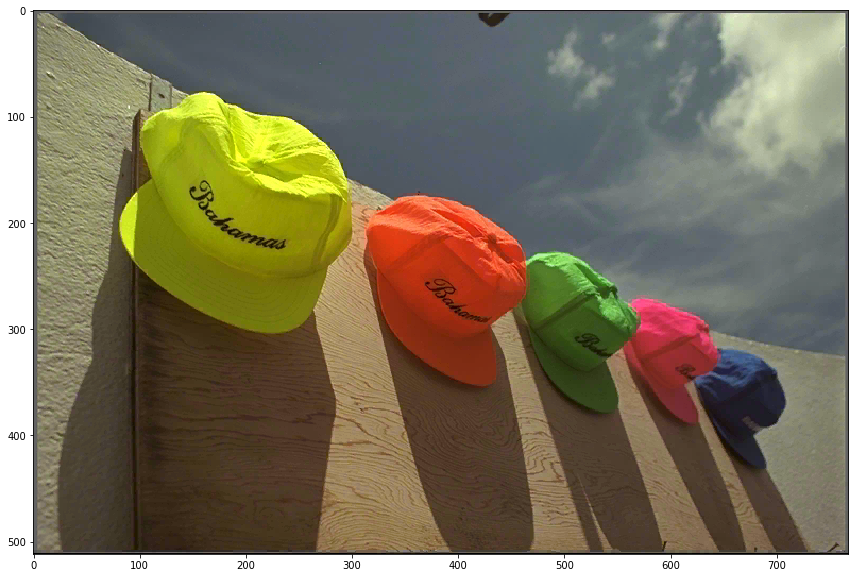

In [6]:
print('Lattice from h-ordering')
smLattice=npToSmil(np.reshape(lattim.lattice,[lattim.nr,lattim.nc]))
disp(smLattice, norm = True)

print('Mapping back from Lattice')
smIm=lattim.mapping_back(lattim.lattice)
disp(smIm)

In [7]:
print(type(lattim.B[0]))
print(len(lattim.hvalues))
print(len(lattim.lattice))
print("max lattice:",np.amax(lattim.lattice))
print("lattim.B max",np.amax(lattim.B))
print("lattim.hvalues max",np.amax(lattim.hvalues))


<class 'numpy.int64'>
7844
393216
max lattice: 7843
lattim.B max 7843
lattim.hvalues max 437.102962699


# Examples of opening and ASF

Number of Different Colors: 7843
Ordering Computed by: norm
npToSmil: uint32
[768, 512, 1]
<class 'smilCorePython.Image_UINT16'>


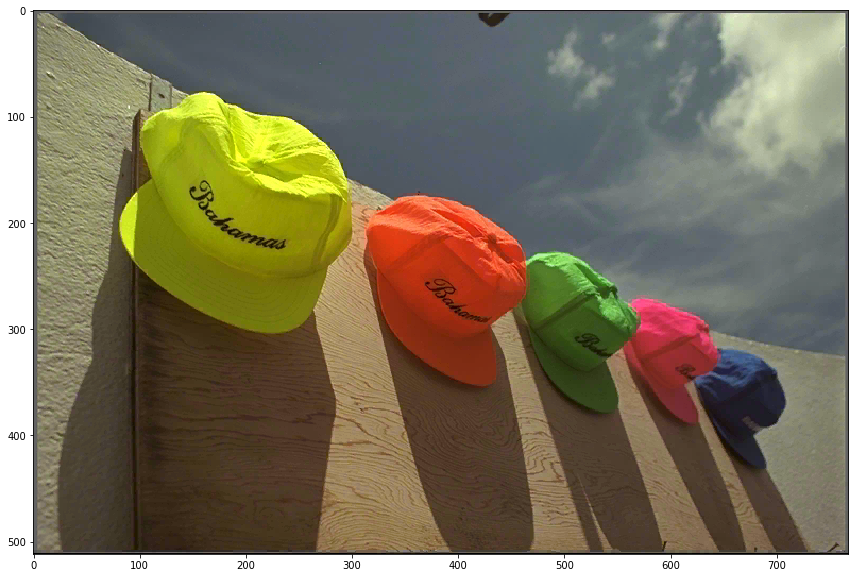

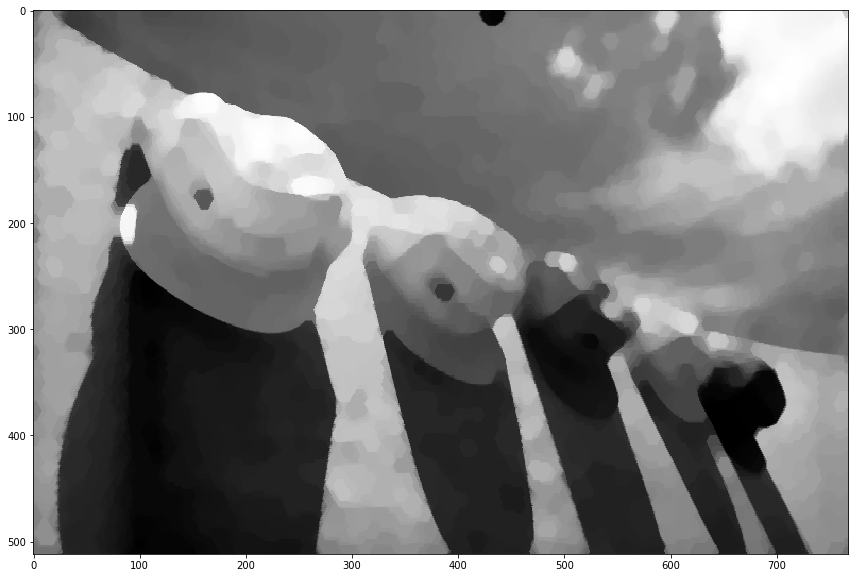

npToSmil: uint8
npToSmil: uint8
npToSmil: uint8


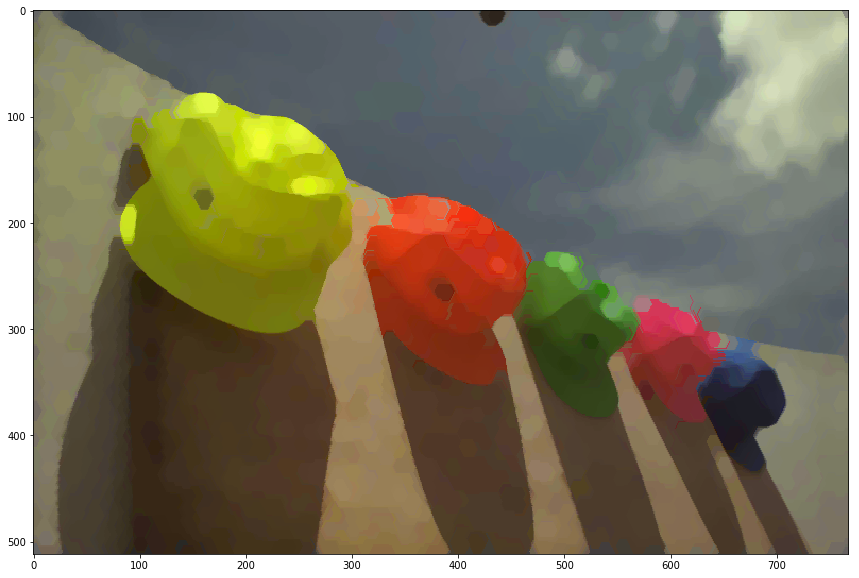

In [8]:
im = Image(images_dir+"Color/kodim03.png")
lattim=smilImageToLattice(im,verbose=True)
lattim.compute_order()
smLattice=npToSmil(np.reshape(lattim.lattice,[lattim.nr,lattim.nc]))
print(smLattice.getSize())
print(type(smLattice))
#open(smLattice,smLattice,HexSE(6))
ASF(smLattice,6,smLattice)
disp(im)
disp(smLattice, norm=True)
newLattice=smilToNP(smLattice)
newIm=lattim.mapping_back(newLattice)
disp(newIm)


In [9]:
print(len(lattim.hvalues))

7844


# Denoising of a color image

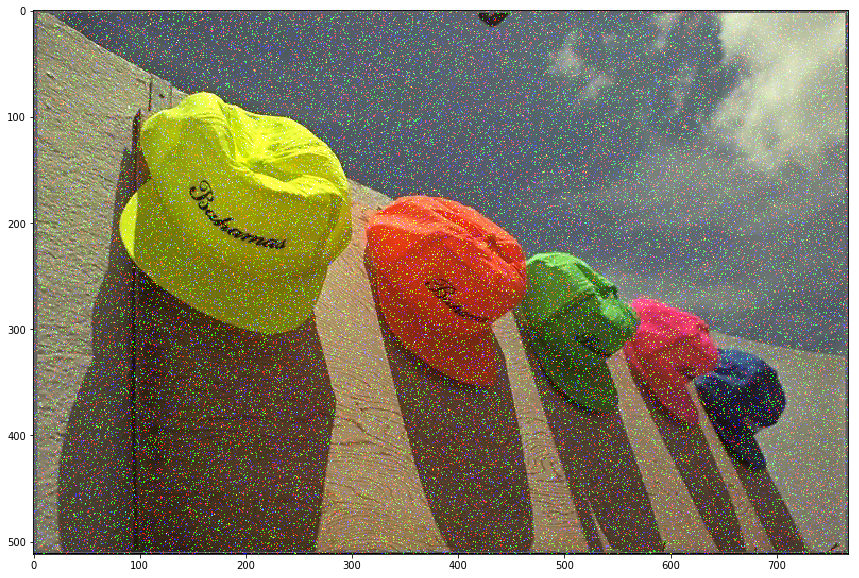

In [10]:
#from scipy.misc import toimage
#from skimage.util import random_noise

im = Image(images_dir+"Color/kodim03_salt.png")
disp(im)


# Example of median filter

Number of Different Colors: 13843
Ordering Computed by: norm
npToSmil: uint32
npToSmil: uint8
npToSmil: uint8
npToSmil: uint8


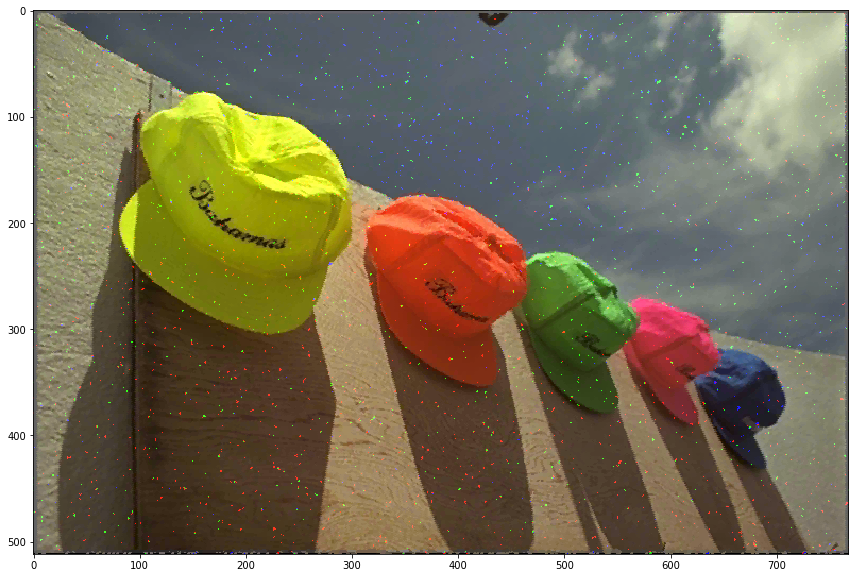

In [11]:
im = Image(images_dir+"Color/kodim03_salt.png")
lattim=smilImageToLattice(im,verbose=True)
lattim.compute_order()
smLattice=npToSmil(np.reshape(lattim.lattice,[lattim.nr,lattim.nc]))
smLattice2 = Image(smLattice)
median(smLattice,smLattice2,HexSE(1))

newLattice=smilToNP(smLattice2)
newIm=lattim.mapping_back(newLattice)
disp(newIm)

In [11]:
maxVal(smLattice)

13843

npToSmil: uint32
npToSmil: uint8
npToSmil: uint8
npToSmil: uint8


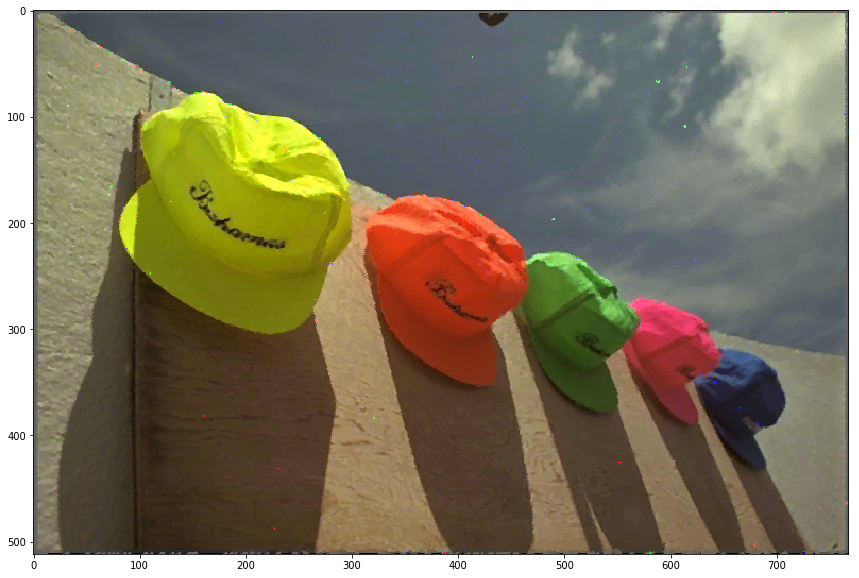

In [12]:
imout=lattim.iterate_operator(median,HexSE(1),niters=3)
disp(imout)

In [12]:
im = Image(images_dir+"Color/kodim03_salt.png")
lattim=smilImageToLattice(im,verbose=True)
lattim.compute_order()
smLattice=npToSmil(np.reshape(lattim.lattice,[lattim.nr,lattim.nc]))
smLattice2 = Image(smLattice)
#median(smLattice,smLattice2,HexSE(1))
#buildASF(smLattice,3,smLattice2)
areaO(smLattice,5,smLattice2)

newLattice=smilToNP(smLattice2)
newIm=lattim.mapping_back(newLattice)
disp(im)
disp(newIm)

Number of Different Colors: 13843
Ordering Computed by: norm
npToSmil: uint32


NameError: name 'openArea' is not defined